# Data Analysis of FIFA 21 Dataset

### Q1: Determine whether the player is over or undervalued based on overall rating and value.

### Import Modules

In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned data (for questions 1 & 2)
df_clean = pd.read_csv('fifa_cleaned.csv')

# For question 3, load the original raw data (adjust path as needed)
df_raw = pd.read_csv('fifa21_raw_data_v2.csv')  # This has individual stats

C:\Users\admin\AppData\Local\Temp\ipykernel_17224\4050673236.py:13: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('fifa21_raw_data_v2.csv')  # This has individual stats


### Create a duplicate copy

In [47]:
df_c = df_clean

### Creating a log value for regression analysis

In [48]:
df_c['Log_Value'] = np.log1p(df_c['Value_int'])

### Assigning the x- and y- variables

In [49]:
x = df_c[['↓OVA']]
y = df_c[['Log_Value']]

### Splitting the data and training the model

In [50]:
# use the same randomness pattern such that the split is reproducible
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = LinearRegression()
model.fit(x_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [51]:
# Pred and eval model
y_pred = model.predict(x_test)
print(f"r2_score: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

r2_score: 0.23
RMSE: 1.83


### What does this mean?
> r2_score of 0.23 means that the overall rating only explains 23% of the variance in value.

> RMSE of 1.83 shows significant prediction errors, likely due to the non-linear relationship/outliers (superstars with enormous values) 

### New Approach -> Considering the relationship is non-linear

- Random Forest Regressor to fit a curved line, considering the non-linear relationship between the overall rating and value of a player
- Winsorize to handle outliers
- Include position specific models to account for different valuations by field position (considering attackers tend to have steeper curves)
- Visualize the scatter plot with a curve regression line, showing over- and under-valued players

### Winsorize data to reduce the impact of outliers by replacing extreme values with less extreme ones, typically at a specified percentile

In [52]:
from scipy.stats.mstats import winsorize

df_c['Value_int_winsor'] = winsorize(df_c['Value_int'], limits=[0,0.05])
df_c['Log_value_winsor'] = np.log1p(df_c["Value_int_winsor"])

In [53]:
df_c.head()

,Nationality,Positions,Best Position,Field Position,Name,Age,Height,Weight,Club,Start Year,...,↓OVA,POT,Value,Value_int,Wage,Wage_amt,Release Clause,Log_Value,Value_int_winsor,Log_value_winsor
0,Argentina,"RW, ST, CF",RW,ATT,L. Messi,33,170cm,72kg,FC Barcelona,2004,...,93,93,€103.5M,103500000.0,€560K,560000.0,€138.4M,18.455082,11500000.0,16.257858
1,Portugal,"ST, LW",ST,ATT,Cristiano Ronaldo,35,187cm,83kg,Juventus,2018,...,92,92,€63M,63000000.0,€220K,220000.0,€75.9M,17.958645,11500000.0,16.257858
2,Slovenia,GK,GK,GK,J. Oblak,27,188cm,87kg,Atlético Madrid,2014,...,91,93,€120M,120000000.0,€125K,125000.0,€159.4M,18.603002,11500000.0,16.257858
3,Belgium,"CAM, CM",CAM,MID,K. De Bruyne,29,181cm,70kg,Manchester City,2015,...,91,91,€129M,129000000.0,€370K,370000.0,€161M,18.675323,11500000.0,16.257858
4,Brazil,"LW, CAM",LW,ATT,Neymar Jr,28,175cm,68kg,Paris Saint-Germain,2017,...,91,91,€132M,132000000.0,€270K,270000.0,€166.5M,18.698312,11500000.0,16.257858


In [54]:
# Features: Only ↓OVA; Target: Log_Value_winsor
x2 = df_c[['↓OVA']]
y2 = df_c['Log_Value']

In [55]:
# Split the data
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

### Random Forest Model for non-linear fit

In [56]:
from sklearn.ensemble import RandomForestRegressor

# n_estimators (num of decision trees): the higher the number, better performance (less variance) but slower training
# setting random_state ensures reproducuibility, where the randomness is exactly the same each time this line is ran
rf_regr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regr.fit(x2_train,y2_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluation of the Random Forest Model

In [57]:
y2_pred_rf = rf_regr.predict(x2_test)
print(y2_pred_rf)

r2 = r2_score(y2_test, y2_pred_rf)
print(f"Overall Random Forest R²: {r2}")

mse = np.sqrt(mean_squared_error(y_test, y2_pred_rf))
print(f"Overall Random Forest RMSE: {mse}")


[12.8330307  13.98504974 14.02514021 ... 14.02514021 14.02514021
 13.29001454]
Overall Random Forest R²: 0.24508539198266777
Overall Random Forest RMSE: 1.8117672047548699


### Predict for all players

In [58]:
# use the regression model to predict, get the predicted log 
df_c['Predicted_log_value'] = rf_regr.predict(x)
# np.expm1(np.log1p(x)) = x
df_c['Predicted_value'] = np.expm1(df_c['Predicted_log_value'])
# get the excess to determine if the player is over or under valued
df_c['Residual_value'] = df_c['Value_int'] - df_c['Predicted_value']
# assigning a valuation status
df_c['Valuation Status'] = np.where(df_c['Residual_value'] > 0, "Overvalued", "Undervalued")
df_c['Valuation Status'] = np.where(abs(df_c['Residual_value']) < df_c['Value_int'] * 0.1, "Fairly Valued", df_c['Valuation Status'])

In [68]:
df_c

,Nationality,Positions,Best Position,Field Position,Name,Age,Height,Weight,Club,Start Year,...,Wage,Wage_amt,Release Clause,Log_Value,Value_int_winsor,Log_value_winsor,Predicted_log_value,Predicted_value,Residual_value,Valuation Status
0,Argentina,"RW, ST, CF",RW,ATT,L. Messi,33,170cm,72kg,FC Barcelona,2004,...,€560K,560000.0,€138.4M,18.455082,11500000.0,16.257858,18.261920,8.532001e+07,1.817999e+07,Overvalued
1,Portugal,"ST, LW",ST,ATT,Cristiano Ronaldo,35,187cm,83kg,Juventus,2018,...,€220K,220000.0,€75.9M,17.958645,11500000.0,16.257858,18.261920,8.532001e+07,-2.232001e+07,Undervalued
2,Slovenia,GK,GK,GK,J. Oblak,27,188cm,87kg,Atlético Madrid,2014,...,€125K,125000.0,€159.4M,18.603002,11500000.0,16.257858,18.614971,1.214449e+08,-1.444925e+06,Fairly Valued
3,Belgium,"CAM, CM",CAM,MID,K. De Bruyne,29,181cm,70kg,Manchester City,2015,...,€370K,370000.0,€161M,18.675323,11500000.0,16.257858,18.614971,1.214449e+08,7.555075e+06,Fairly Valued
4,Brazil,"LW, CAM",LW,ATT,Neymar Jr,28,175cm,68kg,Paris Saint-Germain,2017,...,€270K,270000.0,€166.5M,18.698312,11500000.0,16.257858,18.614971,1.214449e+08,1.055508e+07,Fairly Valued
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,China PR,CB,CB,DEF,Xia Ao,21,178cm,66kg,Wuhan Zall,2018,...,€1K,1000.0,€70K,11.512935,100000.0,11.512935,11.396324,8.899296e+04,1.100704e+04,Overvalued
18975,England,CM,CAM,MID,B. Hough,17,175cm,65kg,Oldham Athletic,2020,...,€500,500.0,€165K,11.775297,130000.0,11.775297,11.396324,8.899296e+04,4.100704e+04,Overvalued
18976,England,CM,CAM,MID,R. McKinley,18,179cm,74kg,Derry City,2019,...,€500,500.0,€131K,11.695255,120000.0,11.695255,11.396324,8.899296e+04,3.100704e+04,Overvalued
18977,China PR,RW,ST,ATT,Wang Zhen'ao,20,175cm,69kg,Dalian YiFang FC,2020,...,€2K,2000.0,€88K,11.512935,100000.0,11.512935,11.396324,8.899296e+04,1.100704e+04,Overvalued


In [70]:
print("\nTop 10 Overvalued Players:")
df_c_output = df_c[['Name', '↓OVA', 'Value_int', 'Value', 'Predicted_value', 'Residual_value', 'Valuation Status']].sort_values('Residual_value', ascending=False)
print(df_c_output[0:10][['Name', 'Value']])
print("\nTop 10 Undervalued Players:")
print(df_c_output[-10:][['Name', 'Value']])


Top 10 Overvalued Players:
                    Name    Value
65            K. Havertz    €121M
8              K. Mbappé  €185.5M
29             J. Sancho    €124M
105           E. Haaland     €92M
280           João Félix   €62.5M
104          L. Martínez   €86.5M
30   T. Alexander-Arnold    €114M
66            M. de Ligt     €99M
370         Vinícius Jr.     €50M
276            Cucurella     €58M

Top 10 Undervalued Players:
              Name   Value
208    S. Mandanda     €4M
92      L. Bonucci    €26M
44       L. Modrić  €36.5M
14        M. Neuer  €17.5M
95        D. Godín  €17.5M
83    Thiago Silva  €14.5M
46       H. Lloris    €26M
38        K. Navas    €26M
39    G. Chiellini    €21M
24   S. Handanovič    €10M


### Plotting a scatter plot with a curved regression line

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


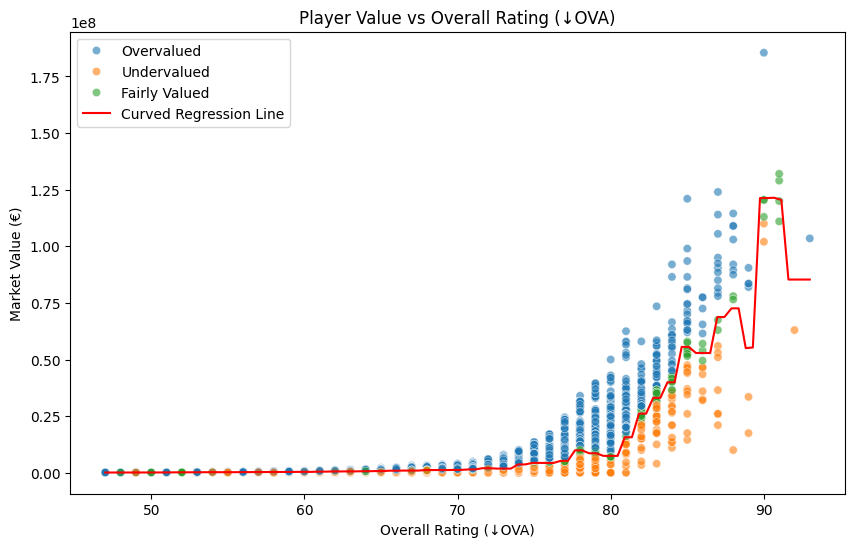

In [ ]:
plt.figure(figsize=(10,6))
# hue: color points by some categorical variable, alpha: make points semi-transparent such that overlapping points are visible
sns.scatterplot(data=df_c, x='↓OVA', y='Value_int', hue='Valuation Status', alpha=0.6)

# x vals for regression line
# linspace creates 100 spaces between the min and max, reshape converts x to a 2D array because scikit model expects x to be a 2D array
x_range = np.linspace(df_c['↓OVA'].min(), df_c['↓OVA'].max(), 100).reshape(-1, 1)

# y vals for regression line
y_pred_line = np.expm1(rf_regr.predict(x_range))

# plotting the regression line
plt.plot(x_range, y_pred_line, color="red", label="Curved Regression Line")

# Add labels, title and legend
plt.title('Player Value vs Overall Rating (OVA)')
plt.xlabel('Overall Rating (↓OVA)')
plt.ylabel('Market Value (€)')
plt.legend()
plt.show()